# Forecast IC-capacity over the next 5 years

In [1]:
# Importeren van de benodigde libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
from os import path, getcwd

## Inladen van de benodigde datasets

In [2]:
# Dataset path
root_dir = path.join(getcwd(), 'Datasets')

# Inlezen benodigde CSV-bestanden
df_per_dag = pd.read_csv(path.join(root_dir, "data_per_dag.csv"))
df_per_leeftijd = pd.read_csv(path.join(root_dir, "data_per_leeftijd.csv"))

# Eerste week van df_per_dag halen, zodat de tijdranges in beide datasets overeen komen.
df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
df_per_dag = df_per_dag.loc[(df_per_dag["Date_adj"] >= "2020-04-01") & (df_per_dag["Date_adj"] < "2021-11-01")]

df_per_dag.head(5)

,Aanwezig op IC verdacht of bewezen Corona,Aanwezig op verpleegafdeling verdacht of bewezen Corona,Opname IC Corona,Opname IC verdacht,Opname IC totaal,Opname verpleegafdeling Corona,Opname verpleegafdeling verdacht,Opname verpleegafdeling totaal,Date_adj,Infection
1,231,1175,23,0,23,130,3,133,2021-10-31,8823
2,222,1119,13,0,13,139,2,141,2021-10-30,8504
3,234,1101,27,0,27,157,2,159,2021-10-29,8440
4,220,1026,23,0,23,136,6,142,2021-10-28,7946
5,216,965,21,0,21,145,5,150,2021-10-27,8499


In [3]:
# Set index dataset

df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
Index_df_per_dag = df_per_dag[["Aanwezig op IC verdacht of bewezen Corona", "Date_adj"]]
Index_df_per_dag.set_index(["Date_adj"], inplace=True)

Index_df_per_dag

,Aanwezig op IC verdacht of bewezen Corona
Date_adj,
2021-10-31,231
2021-10-30,222
2021-10-29,234
2021-10-28,220
2021-10-27,216
...,...
2020-04-05,1312
2020-04-04,1285
2020-04-03,1279


In [4]:
# Replace daily numbers with montly averages
#Index_df_per_dag["IC-capaciteit_log"] = np.log(Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"])
Index_df_per_dag = Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"].resample("MS").sum()

Index_df_per_dag


Date_adj
2020-04-01    32675
2020-05-01    11386
2020-06-01     2867
2020-07-01      963
2020-08-01     1398
2020-09-01     2633
2020-10-01    12265
2020-11-01    18234
2020-12-01    18167
2021-01-01    21706
2021-02-01    15535
2021-03-01    19026
2021-04-01    24316
2021-05-01    21116
2021-06-01     7543
2021-07-01     3535
2021-08-01     6667
2021-09-01     5907
2021-10-01     5163
Freq: MS, Name: Aanwezig op IC verdacht of bewezen Corona, dtype: int64

## Verdelen van de dataset in een train- en testset.

In [5]:
train = Index_df_per_dag[:14]
test = Index_df_per_dag[14:19]
test

Date_adj
2021-06-01    7543
2021-07-01    3535
2021-08-01    6667
2021-09-01    5907
2021-10-01    5163
Freq: MS, Name: Aanwezig op IC verdacht of bewezen Corona, dtype: int64

# Building the ARIMA-model
1. Predict p, q and d
2. Build model
3. Visualize model
4. Evaluate model

In [6]:
# Get P-value
from statsmodels.tsa.stattools import adfuller
diff_1 = Index_df_per_dag.diff().dropna()
print("p-value:", adfuller(diff_1)[1])

p-value: 0.20309299477262355


Uit de resultaten van bovenstaande cel blijkt de p-value, die de stationary van de data weergeeft, pas na een diff toe te passen op een waarde onder de 0,05 uit te komen. Hieruit kan geconcludeerd worden dat de d binnen het Arima-model de waarde **0** dient te krijgen.

In [22]:
# Predict p, q and d
import itertools
from sklearn.metrics import mean_squared_error

p=range(0,8)
q=range(0,8)
d=range(0,1)

pdq_combination = list(itertools.product(p,d,q))

rmse=[]
order1=[]

for pdq in pdq_combination:
    try:
        model= ARIMA(train, order=pdq).fit()
        pred = model.predict(start=len(train), end=(len(Index_df_per_dag) -1))
        error = np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)

    except:
        continue


results = pd.DataFrame(index=order1, data=rmse, columns= ["RMSE"])

results.to_excel("Arima_results.xlsx")

,RMSE
"(0, 0, 0)",8792.839150
"(0, 0, 1)",9327.606891
"(0, 0, 2)",7229.133842
"(0, 0, 3)",10082.085187
"(0, 0, 5)",7308.948949
"(0, 0, 6)",7575.046749
"(0, 0, 7)",6913.448633
"(1, 0, 0)",11396.077983
"(1, 0, 1)",10547.681735
"(1, 0, 2)",10544.026107


In [8]:
# Build model
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

model = ARIMA(train, order=(2,0,2)).fit()

pred = model.predict(start=len(train), end=(len(Index_df_per_dag) -1))

Text(0, 0.5, 'Benodigde IC-capaciteit per maand.')

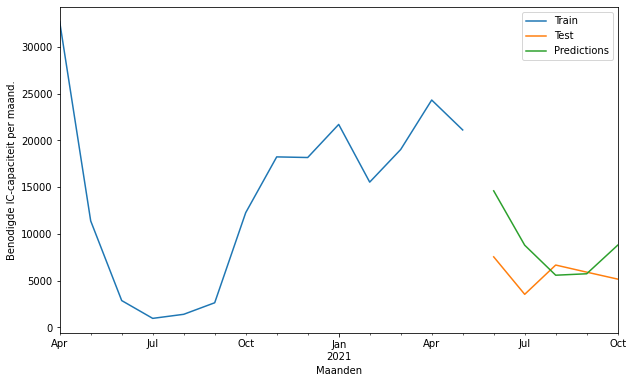

In [9]:
# Plot train, test and predicted values
train.plot(legend=True, label="Train", figsize=(10,6))
test.plot(legend=True, label="Test")
pred.plot(legend=True, label="Predictions")
plt.xlabel("Maanden")
plt.ylabel("Benodigde IC-capaciteit per maand.")

In [10]:
# Get Metrics of the model

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mean absolute percentage error':mape, 'mean error':me, 'mean absolute error': mae, 
            'mean percentage error': mpe, 'root mean squarred error':rmse, 
            'correlation':corr, 'minmax':minmax})

forecast_accuracy(pred, test.values)

{'mean absolute percentage error': 0.663471067648567,
 'mean error': 2935.9967958370853,
 'mean absolute error': 3440.542212021182,
 'mean percentage error': 0.5864545083328241,
 'root mean squarred error': 4285.147798826442,
 'correlation': 0.3138630029669493,
 'minmax': 0.33729661027343205}

Text(0, 0.5, 'Benodige IC-capaciteit per maand')

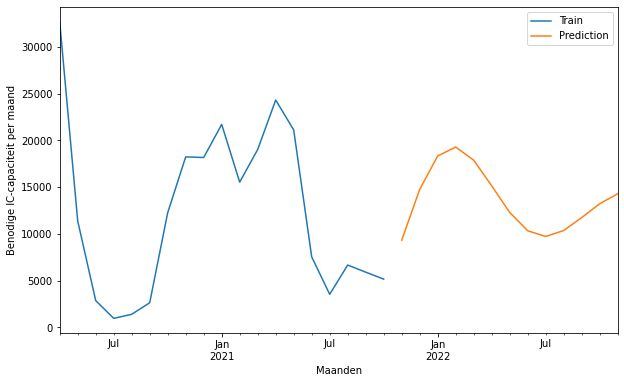

In [11]:
# Predict the future data.
final_model = ARIMA(Index_df_per_dag, order=(2,0,2)).fit()

prediction = final_model.predict(len(Index_df_per_dag), len(Index_df_per_dag) + 12)

Index_df_per_dag.plot(legend=True, label="Train", figsize=(10,6))
prediction.plot(legend=True, label="Prediction")
plt.xlabel("Maanden")
plt.ylabel("Benodige IC-capaciteit per maand")

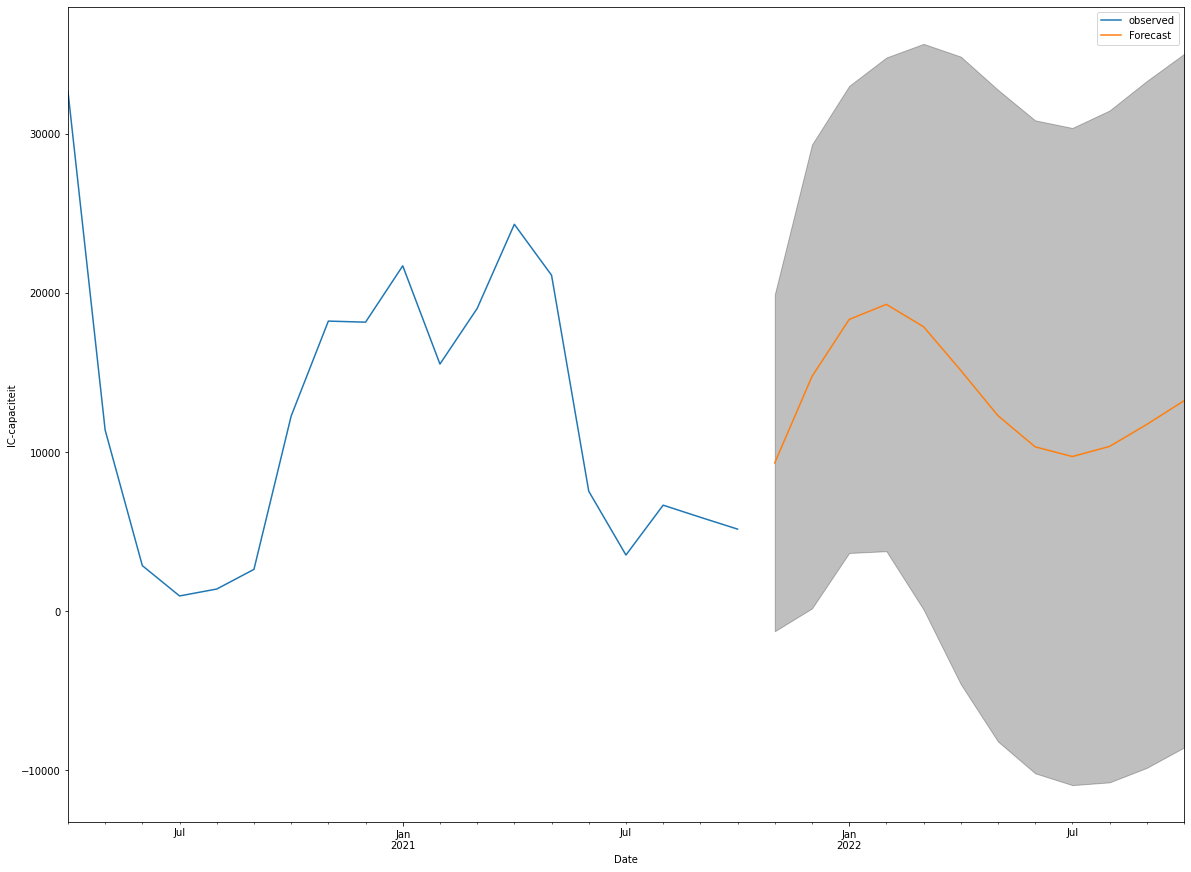

In [12]:
# Dezelfde plot als bovenstaande cel, met onzekerheid.
# Get forecast 12 steps ahead in future
pred_uc = final_model.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
#pred_ci = np.exp(pred_ci)

# Plot the model
ax = Index_df_per_dag.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('IC-capaciteit')

plt.legend()
plt.show()

In [21]:
# De negatieve waardes bij lower moeten weggewerkt worden.
pred_ci

,lower Aanwezig op IC verdacht of bewezen Corona,upper Aanwezig op IC verdacht of bewezen Corona
Date_adj,,
2021-06-01,1174.174946,22438.155170
2021-07-01,-10900.271577,10334.633640
2021-08-01,-7040.720732,14169.604248
2021-09-01,-2412.347070,18777.111106
2021-10-01,-3038.891525,18132.772981


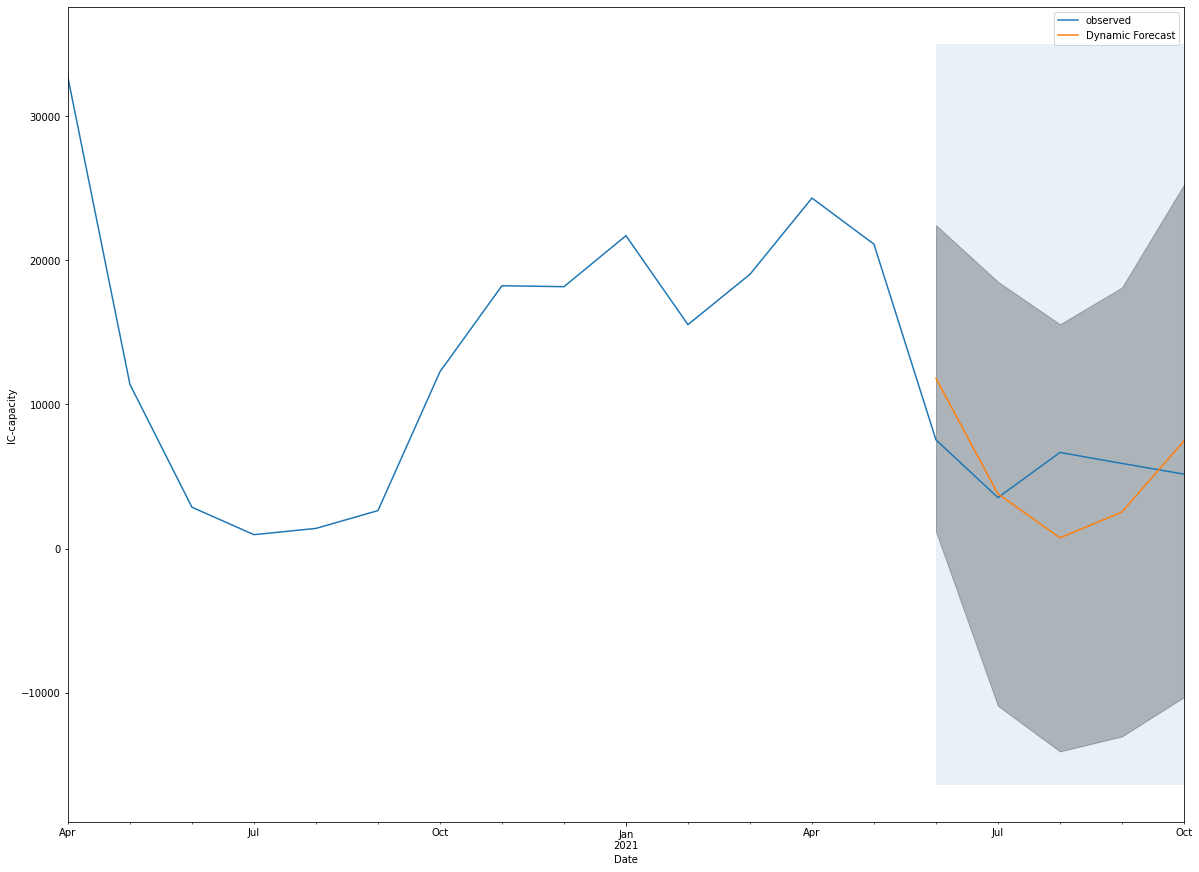

In [13]:
# Deze en onderstaande cel geven de forecasting over een aantal maanden weer.

pred_dynamic = final_model.get_prediction(start=pd.to_datetime('2021-06-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = Index_df_per_dag['2020':].plot(label='observed', figsize=(20,15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-06-01'), Index_df_per_dag.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')

plt.legend()
plt.show()

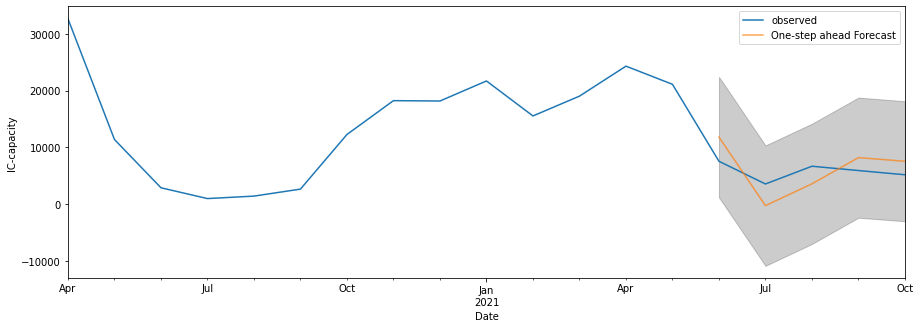

In [15]:
pred = final_model.get_prediction(start=pd.to_datetime('2021-06-01'), dynamic=False)
pred_ci = pred.conf_int()

# Plotting IC-capacity
ax = Index_df_per_dag['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(15,5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
plt.legend()

plt.show()

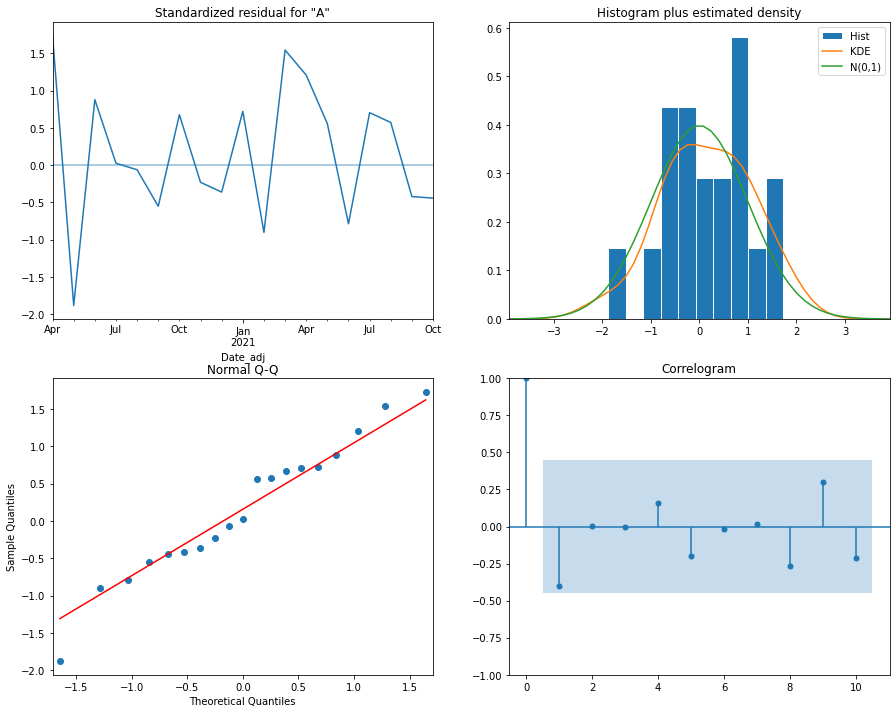

In [14]:
# Forecast testdata
final_model.plot_diagnostics(figsize=(15, 12))
plt.show()

# Validate model with 2020 data

In [17]:
# Create Train and Test set
train_2020 = Index_df_per_dag[:9]
test_2021 = Index_df_per_dag[9:]
test_2021

Date_adj
2021-01-01    21706
2021-02-01    15535
2021-03-01    19026
2021-04-01    24316
2021-05-01    21116
2021-06-01     7543
2021-07-01     3535
2021-08-01     6667
2021-09-01     5907
2021-10-01     5163
Freq: MS, Name: Aanwezig op IC verdacht of bewezen Corona, dtype: int64

In [18]:
model_2020 = ARIMA(train, order=(2,0,2)).fit()

pred_2020 = model_2020.predict(start=len(train_2020), end=(len(Index_df_per_dag) -1))

Text(0, 0.5, 'Benodigde IC-capaciteit per maand.')

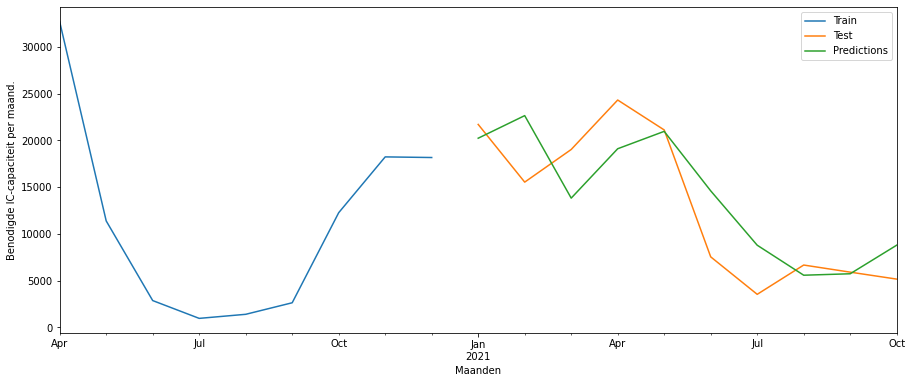

In [19]:
# Visualize predictions v.s. test values
train_2020.plot(legend=True, label="Train", figsize=(15,6))
test_2021.plot(legend=True, label="Test")
pred_2020.plot(legend=True, label="Predictions")
plt.xlabel("Maanden")
plt.ylabel("Benodigde IC-capaciteit per maand.")

In [20]:
# Get the metrics of the model
forecast_accuracy(pred_2020, test_2021.values)

{'mean absolute percentage error': 0.4338005597333695,
 'mean error': 975.4520668045325,
 'mean absolute error': 3635.374819892804,
 'mean percentage error': 0.2827333504181373,
 'root mean squarred error': 4458.798520178174,
 'correlation': 0.8220879344835804,
 'minmax': 0.25633387132488117}